## Registering Spatial Metabolomics data to Spatial Transcriptomics data using STalign 

### 1) Import Spatial Metabolomics Data


Layer 1: searching in /stornext/Bioinf/data/lab_brain_cancer/projects/tme_spatial/venture_multi_omics/venture_pt2/integrated/layer_1/matrix
  Processing file 1: Ven2A_edge_removed_filtered.csv

Layer 2: searching in /stornext/Bioinf/data/lab_brain_cancer/projects/tme_spatial/venture_multi_omics/venture_pt2/integrated/layer_2/matrix
  Processing file 1: Ven2B_edge_removed_filtered.csv

Layer 3: searching in /stornext/Bioinf/data/lab_brain_cancer/projects/tme_spatial/venture_multi_omics/venture_pt2/integrated/layer_3/matrix
  Processing file 1: Ven2C_edge_removed_filtered.csv

Layer 4: searching in /stornext/Bioinf/data/lab_brain_cancer/projects/tme_spatial/venture_multi_omics/venture_pt2/integrated/layer_4/matrix
  Processing file 1: Ven2D_edge_removed_filtered.csv

Layer 5: searching in /stornext/Bioinf/data/lab_brain_cancer/projects/tme_spatial/venture_multi_omics/venture_pt2/integrated/layer_5/matrix
  Processing file 1: Ven2E_edge_removed_filtered.csv

Layer 6: searching in /storne

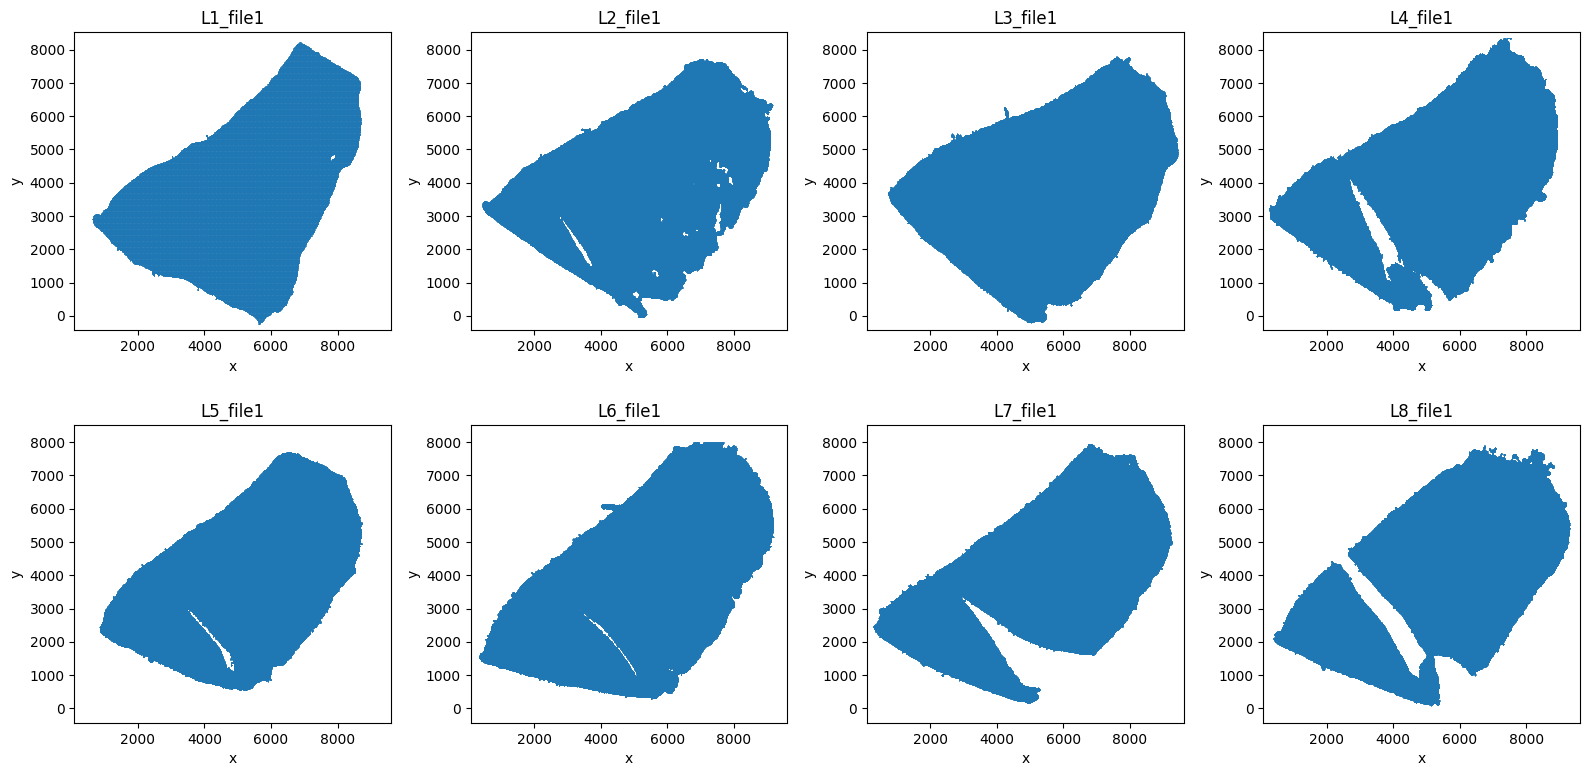

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from typing import Dict, List
from typing import Iterable, Optional, Set
import matplotlib.pyplot as plt


BASE_PATH = "/stornext/Bioinf/data/lab_brain_cancer/projects/tme_spatial/venture_multi_omics/venture_pt2/integrated/"
# file: prefix_numeric_headers.py

import pandas as pd


def is_numeric_like_header(name: str) -> bool:
    """
    Returns True if the header starts with a digit or with '.' followed by a digit.
    Examples considered numeric-like: '72.08', '0.5', '.5', '391.278...'
    """
    if not isinstance(name, str):
        return False
    s = name.strip()
    if not s:
        return False
    return s[0].isdigit() or (s[0] == '.' and len(s) > 1 and s[1].isdigit())

def add_x_prefix_to_numeric_headers(
    df: pd.DataFrame,
    exclude: Optional[Iterable[str]] = None,
    already_prefixed_ok: bool = True
) -> pd.DataFrame:
    """
    Return a copy of df where any numeric-like column headers are prefixed with 'X'.
    - exclude: columns to leave unchanged (e.g., {'x','y','is_edge'}), case-sensitive match
    - already_prefixed_ok: if True, leaves headers that already start with 'X' unchanged

    Examples:
      '72.0796' -> 'X72.0796'
      '.5' -> 'X.5'
      'x', 'y', 'is_edge' -> unchanged (if included in exclude)
    """
    exclude_set: Set[str] = set(exclude or [])

    def new_name(col: str) -> str:
        if col in exclude_set:
            return col
        if is_numeric_like_header(col):
            if already_prefixed_ok and col.startswith('X'):
                return col
            return f"X{col}"
        return col

    mapping = {col: new_name(col) for col in df.columns}
    if any(mapping[k] != k for k in mapping):
        return df.rename(columns=mapping)
    return df
    
def read_sm_matrix(mtx_file, verbose=True):
    """
    Read a Spatial Metabolomics matrix file and return the full DataFrame with:
      - x,y standardized as 'x','y'
      - numeric-like feature headers prefixed with 'X' (e.g., 72.0796 -> X72.0796)
    """
    if verbose:
        print(f"Reading matrix file: {os.path.basename(mtx_file)}")

    try:
        # Let pandas detect the separator
        df = pd.read_csv(mtx_file, sep=None, engine='python')

        # Identify coordinate and optional is_edge columns (case-insensitive)
        x_col = next((col for col in df.columns if col.lower() == 'x'), None)
        y_col = next((col for col in df.columns if col.lower() == 'y'), None)
        is_edge_col = next((col for col in df.columns if col.lower() == 'is_edge'), None)

        if x_col is None or y_col is None:
            print(f"Available columns: {', '.join(df.columns)}")
            raise ValueError("Could not find 'x' and 'y' columns in the data")

        # Standardize x/y names
        rename_xy = {}
        if x_col != 'x':
            rename_xy[x_col] = 'x'
        if y_col != 'y':
            rename_xy[y_col] = 'y'
        if rename_xy:
            df = df.rename(columns=rename_xy)

        # Prefix numeric-like headers with 'X' excluding x, y, is_edge
        exclude = {'x', 'y'}
        if is_edge_col is not None:
            # If is_edge column was not named exactly 'is_edge', preserve its name during exclude
            # (after add_x_prefix_to_numeric_headers we keep it unchanged as well)
            exclude.add(is_edge_col if is_edge_col in df.columns else 'is_edge')

        df = add_x_prefix_to_numeric_headers(df, exclude=exclude, already_prefixed_ok=True)

    except Exception as e:
        raise Exception(f"Error reading matrix file {os.path.basename(mtx_file)}: {str(e)}")

    if verbose:
        print(f"Loaded rows: {len(df)}, columns: {len(df.columns)}")

    return df


def find_layer_matrix_files(base_path: str, layers: List[int]) -> Dict[int, List[str]]:
    """
    For each layer in `layers`, find all matching matrix files under:
      base_path/layer_{X}/matrix/*_edge_removed_filtered.csv
    Returns dict: layer -> list of file paths
    """
    layer_files: Dict[int, List[str]] = {}
    for layer in layers:
        matrix_dir = os.path.join(base_path, f"layer_{layer}", "matrix")
        files = sorted(glob.glob(os.path.join(matrix_dir, "*_edge_removed_filtered.csv")))
        layer_files[layer] = files
    return layer_files


def process_matrices_by_layers(base_path: str, layers: List[int]) -> Dict[str, pd.DataFrame]:
    """
    Process matrices grouped by specified layers.
    Returns a dict mapping:
      key -> full DataFrame with x,y and X-prefixed feature columns
    Keys:
      - L{layer}_file{index}
      - If z-plane marker present (e.g., *_z3_*), also L{layer}_Z{z}
    """
    layer_files = find_layer_matrix_files(base_path, layers)

    outputs: Dict[str, pd.DataFrame] = {}
    any_files = False

    for layer, files in layer_files.items():
        print(f"\nLayer {layer}: searching in {os.path.join(base_path, f'layer_{layer}', 'matrix')}")
        if not files:
            print(f"  No matrix files found for layer {layer}")
            continue

        any_files = True
        for i, file_path in enumerate(files, start=1):
            try:
                z_plane = None
                fname = os.path.basename(file_path)
                parts = fname.split('_')
                for p in parts:
                    if p.lower().startswith('z') and p[1:].isdigit():
                        z_plane = p[1:]
                        break
                    if p.lower().startswith('z') and len(p) > 1 and p[1].isdigit():
                        digits = ''.join(ch for ch in p[1:] if ch.isdigit())
                        if digits:
                            z_plane = digits
                            break

                print(f"  Processing file {i}: {fname}" + (f" (z={z_plane})" if z_plane else ""))
                df = read_sm_matrix(file_path, verbose=False)

                base_key = f"L{layer}_file{i}"
                outputs[base_key] = df

                if z_plane is not None:
                    z_key = f"L{layer}_Z{z_plane}"
                    outputs[z_key] = df

            except Exception as e:
                print(f"  Error processing {fname}: {str(e)}")
                print("  Continuing with next file...")
                continue

    if not any_files:
        raise Exception("No matrix files found across all specified layers")

    return outputs  # <-- add this


def plot_dfs_side_by_side(dfs_by_key: Dict[str, pd.DataFrame], ncols: int = None, point_size: float = 0.5, alpha: float = 0.6, equal_axes: bool = True, share_limits: bool = True):
    """
    Plot all DataFrames side-by-side as x vs y scatter plots.
    """
    if not dfs_by_key:
        print("No DataFrames to plot.")
        return

    keys = list(sorted(dfs_by_key.keys()))
    n = len(keys)
    if ncols is None:
        ncols = min(4, n)
    nrows = int(np.ceil(n / ncols))

    # Compute global limits if requested
    xlim = ylim = None
    if share_limits:
        xs, ys = [], []
        for k in keys:
            df = dfs_by_key[k]
            if 'x' in df.columns and 'y' in df.columns:
                xs.append(df['x'].values)
                ys.append(df['y'].values)
        if xs and ys:
            x_all = np.concatenate(xs)
            y_all = np.concatenate(ys)
            xpad = (x_all.max() - x_all.min()) * 0.02 if x_all.size else 0
            ypad = (y_all.max() - y_all.min()) * 0.02 if y_all.size else 0
            xlim = (x_all.min() - xpad, x_all.max() + xpad)
            ylim = (y_all.min() - ypad, y_all.max() + ypad)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), squeeze=False)
    axes = axes.flatten()

    for i, key in enumerate(keys):
        ax = axes[i]
        df = dfs_by_key[key]
        if 'x' not in df.columns or 'y' not in df.columns:
            ax.set_title(f"{key} (no x/y)")
            ax.axis('off')
            continue
        ax.scatter(df['x'], df['y'], s=point_size, c='tab:blue', alpha=alpha, linewidths=0)
        ax.set_title(key)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        if equal_axes:
            ax.set_aspect('equal', adjustable='box')
        if xlim is not None and ylim is not None:
            ax.set_xlim(*xlim)
            ax.set_ylim(*ylim)

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    # remove: return outputs



# Usage example
if __name__ == "__main__":
    layers_to_process = [1,2,3,4,5,6,7,8]
    try:
        dfs_by_key = process_matrices_by_layers(BASE_PATH, layers_to_process)

        print("\nProcessing Summary:")
        for key in sorted(dfs_by_key.keys()):
            df = dfs_by_key[key]
            x_prefixed = sum(1 for c in df.columns if isinstance(c, str) and c.startswith('X') and c not in {'X', 'XY'})
            print(f"{key}: shape={df.shape}, X-prefixed features≈{x_prefixed}")

        # Plot all DataFrames side by side
        plot_dfs_side_by_side(dfs_by_key, ncols=min(4, len(dfs_by_key)))

    except Exception as e:
        print(f"Error in main execution: {str(e)}")

### 2)Import Spatial Transcriptomics Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


import os
from STalign import STalign
import torch
import os
import tifffile as tf
from tifffile import imread 

In [5]:
v2_all=pd.read_csv('/stornext/Bioinf/data/lab_brain_cancer/projects/tme_spatial/transcriptomics/venture/Ven2_23BCRL059T/data/out/aligned_annotations_240620.csv')

In [6]:
z1=v2_all[v2_all['layer']=='z1']
z2=v2_all[v2_all['layer']=='z2']
z3=v2_all[v2_all['layer']=='z3']
z4=v2_all[v2_all['layer']=='z4']
z5=v2_all[v2_all['layer']=='z5']
z6=v2_all[v2_all['layer']=='z6']
z7=v2_all[v2_all['layer']=='z7']
z8=v2_all[v2_all['layer']=='z8']

In [7]:
xA = np.array(z1['x_centroid'])
yA = np.array(z1['y_centroid'])
xB = np.array(z2['x_centroid'])
yB = np.array(z2['y_centroid'])
xC = np.array(z3['x_centroid'])
yC = np.array(z3['y_centroid'])
xD = np.array(z4['x_centroid'])
yD = np.array(z4['y_centroid'])
xE = np.array(z5['x_centroid'])
yE = np.array(z5['y_centroid'])
xF = np.array(z6['x_centroid'])
yF = np.array(z6['y_centroid'])
xG = np.array(z7['x_centroid'])
yG = np.array(z7['y_centroid'])
xH = np.array(z8['x_centroid'])
yH = np.array(z8['y_centroid'])

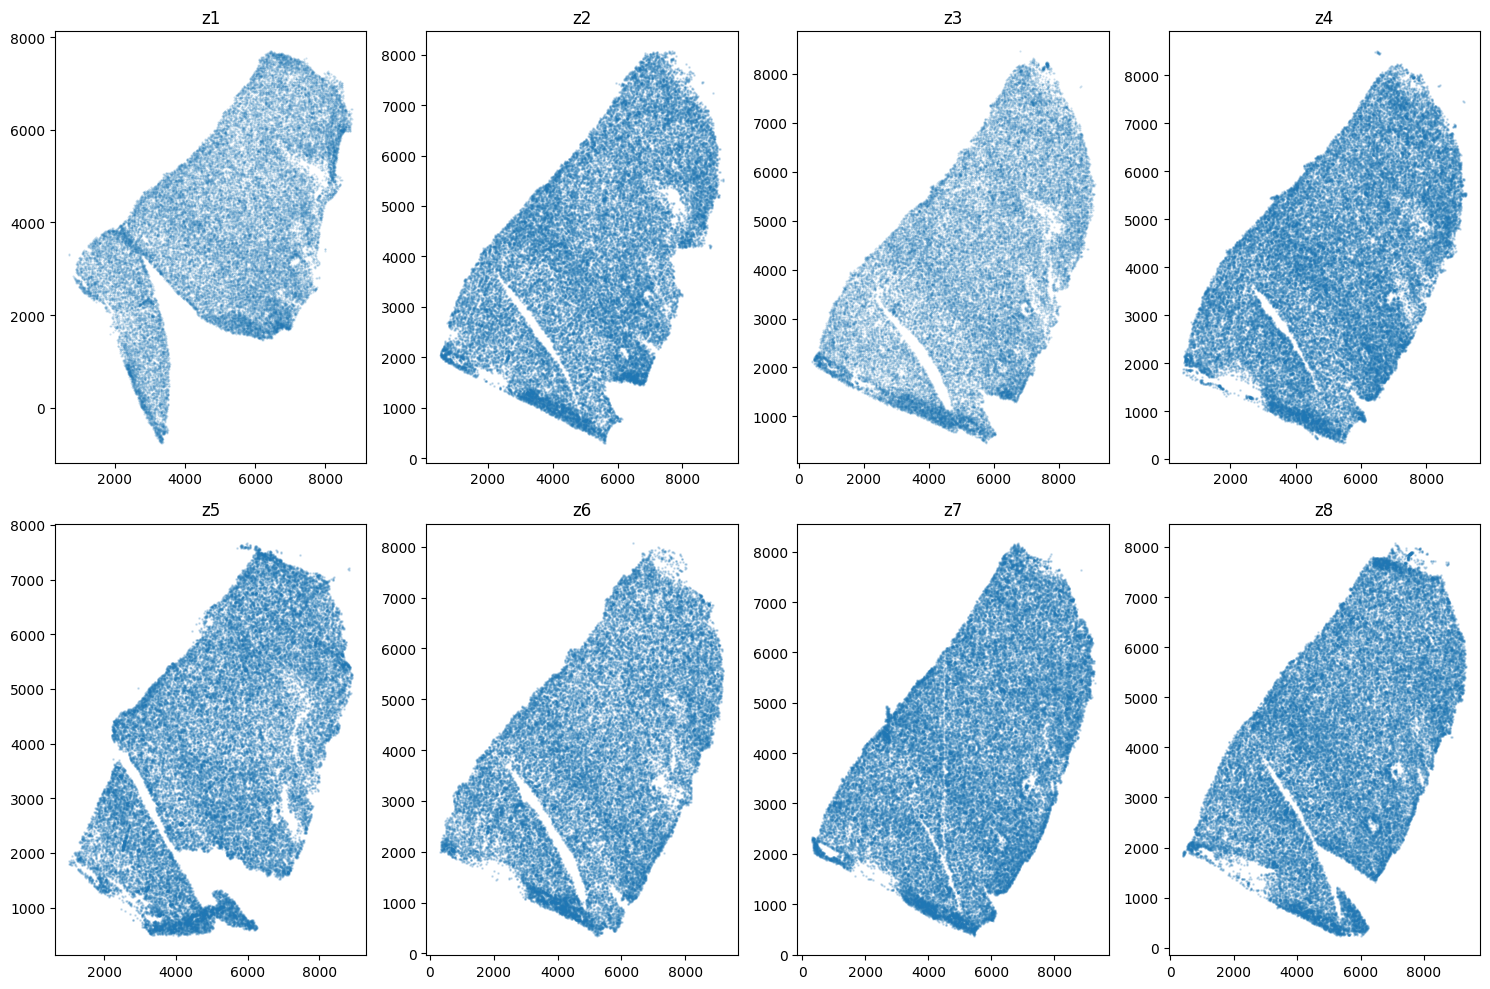

In [8]:
fig, axs=plt.subplots(2,4,figsize=(15,10))

axs[0,0].scatter(xA,yA,s=0.3,alpha=0.2)
axs[0,0].set_title('z1')

axs[0,1].scatter(xB,yB,s=0.8,alpha=0.2)
axs[0,1].set_title('z2')

axs[0,2].scatter(xC,yC,s=0.3,alpha=0.2)
axs[0,2].set_title('z3')

axs[0,3].scatter(xD,yD,s=0.8,alpha=0.2)
axs[0,3].set_title('z4')

axs[1,0].scatter(xE,yE,s=0.8,alpha=0.2)
axs[1,0].set_title('z5')

axs[1,1].scatter(xF,yF,s=0.8,alpha=0.2)
axs[1,1].set_title('z6')

axs[1,2].scatter(xG,yG,s=0.8,alpha=0.2)
axs[1,2].set_title('z7')

axs[1,3].scatter(xH,yH,s=0.8,alpha=0.2)
axs[1,3].set_title('z8')

plt.tight_layout()
plt.show()

## Rasterize Points for Alignmnet 

### ST Data

0 of 39804
10000 of 39804
20000 of 39804
30000 of 39804
39803 of 39804
0 of 41726
10000 of 41726
20000 of 41726
30000 of 41726
40000 of 41726
41725 of 41726
0 of 43723
10000 of 43723
20000 of 43723
30000 of 43723
40000 of 43723
43722 of 43723
0 of 49602
10000 of 49602
20000 of 49602
30000 of 49602
40000 of 49602
49601 of 49602
0 of 43659
10000 of 43659
20000 of 43659
30000 of 43659
40000 of 43659
43658 of 43659
0 of 40227
10000 of 40227
20000 of 40227
30000 of 40227
40000 of 40227
40226 of 40227
0 of 50441
10000 of 50441
20000 of 50441
30000 of 50441
40000 of 50441
50000 of 50441
50440 of 50441
0 of 49289
10000 of 49289
20000 of 49289
30000 of 49289
40000 of 49289
49288 of 49289


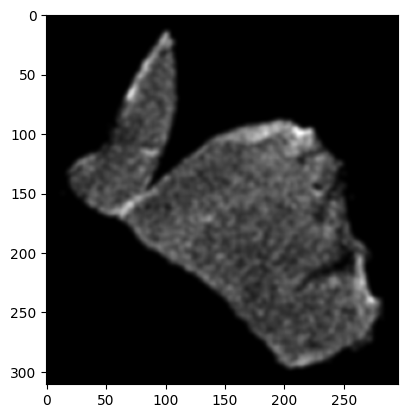

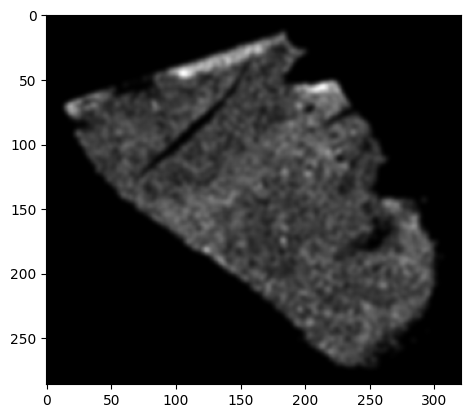

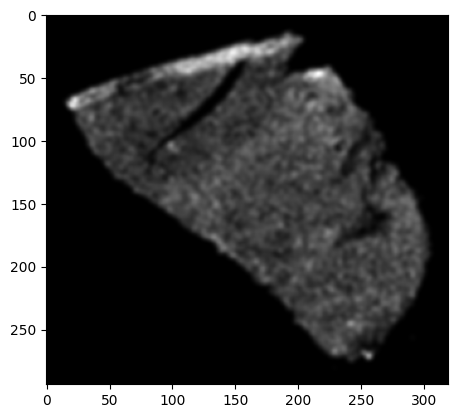

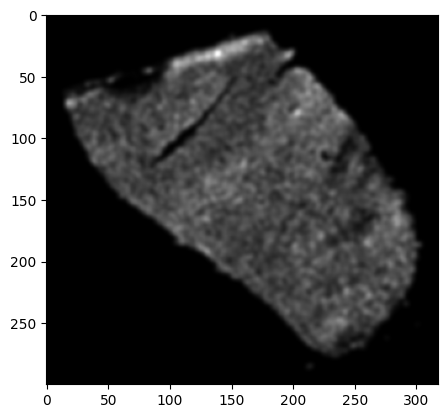

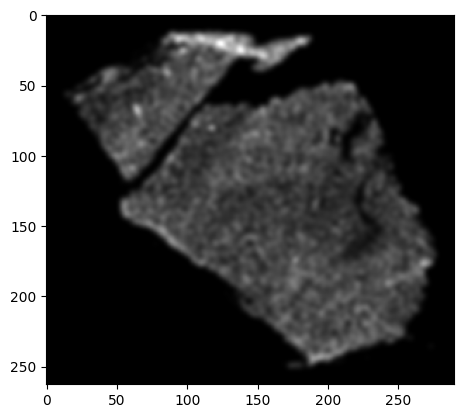

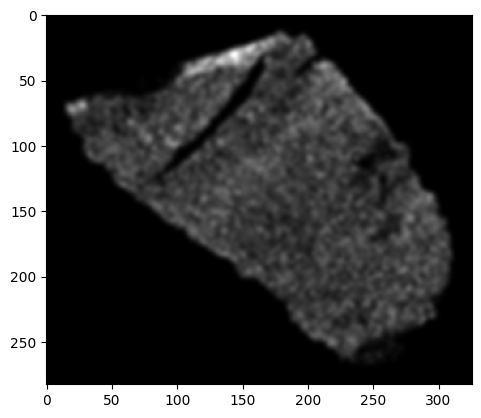

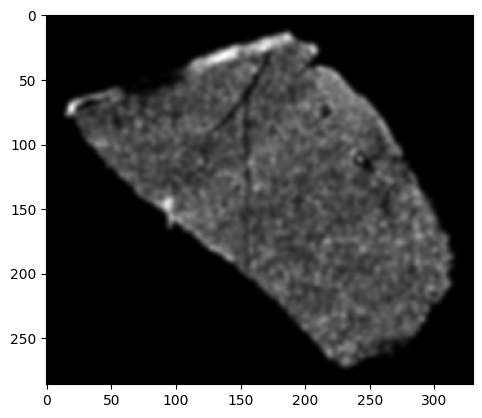

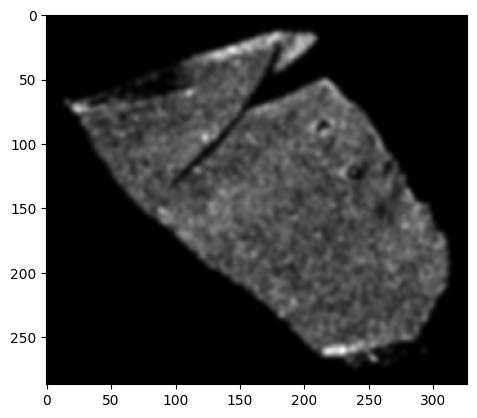

In [11]:
XA,YA,AZ,figA=STalign.rasterize(xA,yA, dx=30)
XB,YB,BZ,figB=STalign.rasterize(xB,yB, dx=30)
XC,YC,CZ,figC=STalign.rasterize(xC,yC, dx=30)
XD,YD,DZ,figD=STalign.rasterize(xD,yD, dx=30)
XE, YE, EZ, figE=STalign.rasterize(xE,yE, dx=30)
XF, YF, FZ, figF=STalign.rasterize(xF,yF, dx=30)
XG, YG, GZ, figG=STalign.rasterize(xG,yG, dx=30)
XH, YH, HZ, figG=STalign.rasterize(xH,yH, dx=30)

In [26]:
#save as npz for landmark assignment if necessary 
np.savez('/vast/projects/BCRL_Multi_Omics/stalign_results/z1_st_points.npz', x=XA,y=YA,I=AZ)


### SM Data

In [12]:
z1_met = dfs_by_key['L1_file1']
z2_met = dfs_by_key['L2_file1']
z3_met = dfs_by_key['L3_file1']
z4_met = dfs_by_key['L4_file1']
z5_met = dfs_by_key['L5_file1']
z6_met = dfs_by_key['L6_file1']
z7_met = dfs_by_key['L7_file1']
z8_met = dfs_by_key['L8_file1']

In [13]:

xA_met = np.array(z1_met['x'])
yA_met = np.array(z1_met['y'])
xB_met = np.array(z2_met['x'])
yB_met = np.array(z2_met['y'])
xC_met = np.array(z3_met["x"])
yC_met = np.array(z3_met['y'])
xD_met = np.array(z4_met['x'])
yD_met = np.array(z4_met['y'])
xE_met = np.array(z5_met['x'])
yE_met = np.array(z5_met['y'])
xF_met = np.array(z6_met['x'])
yF_met = np.array(z6_met['y'])
xG_met = np.array(z7_met['x'])
yG_met = np.array(z7_met['y'])
xH_met = np.array(z8_met['x'])
yH_met = np.array(z8_met['y'])


0 of 195213
10000 of 195213
20000 of 195213
30000 of 195213
40000 of 195213
50000 of 195213
60000 of 195213
70000 of 195213
80000 of 195213
90000 of 195213
100000 of 195213
110000 of 195213
120000 of 195213
130000 of 195213
140000 of 195213
150000 of 195213
160000 of 195213
170000 of 195213
180000 of 195213
190000 of 195213
195212 of 195213
0 of 313488
10000 of 313488
20000 of 313488
30000 of 313488
40000 of 313488
50000 of 313488
60000 of 313488
70000 of 313488
80000 of 313488
90000 of 313488
100000 of 313488
110000 of 313488
120000 of 313488
130000 of 313488
140000 of 313488
150000 of 313488
160000 of 313488
170000 of 313488
180000 of 313488
190000 of 313488
200000 of 313488
210000 of 313488
220000 of 313488
230000 of 313488
240000 of 313488
250000 of 313488
260000 of 313488
270000 of 313488
280000 of 313488
290000 of 313488
300000 of 313488
310000 of 313488
313487 of 313488
0 of 339488
10000 of 339488
20000 of 339488
30000 of 339488
40000 of 339488
50000 of 339488
60000 of 339488
70

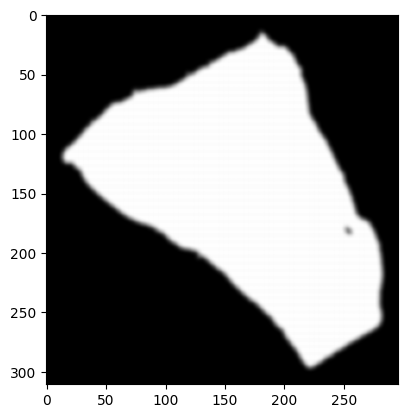

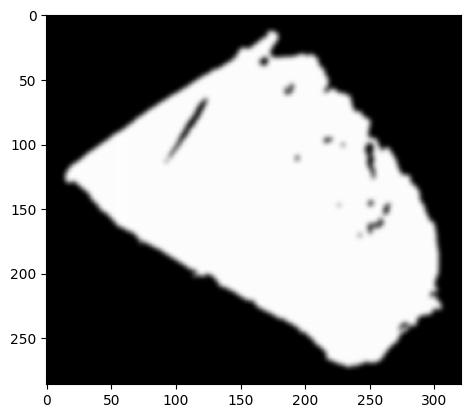

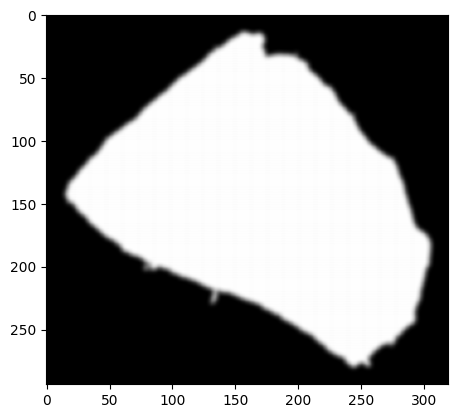

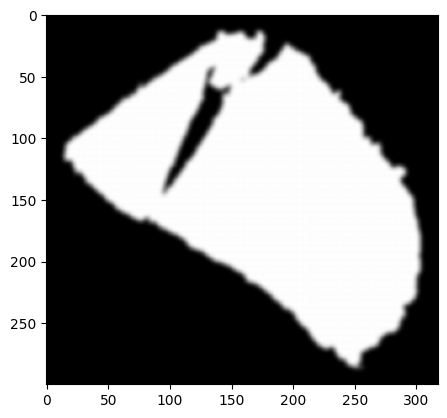

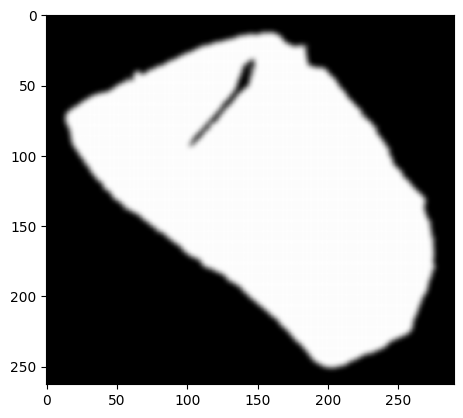

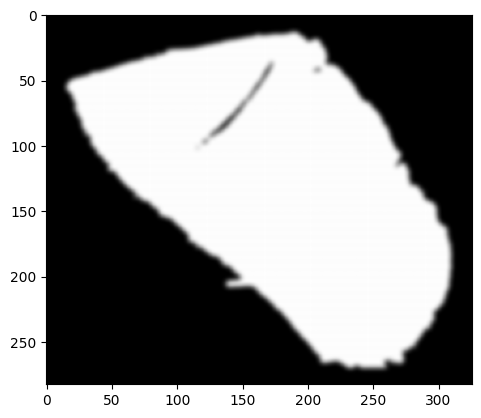

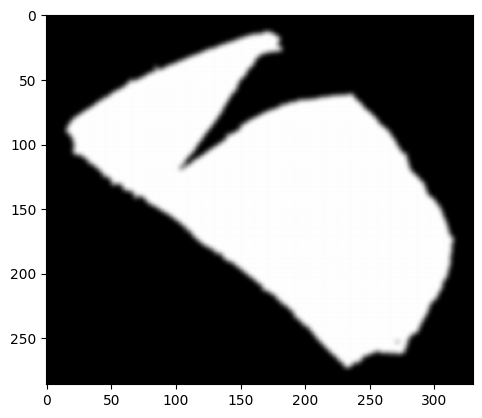

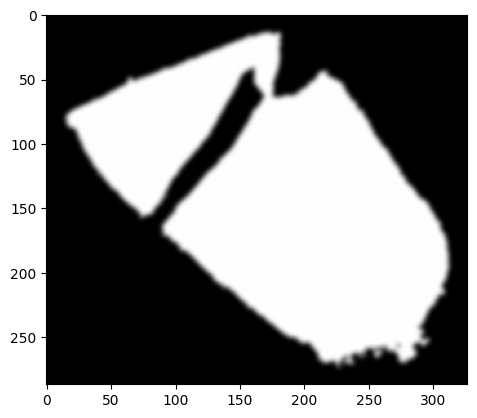

In [14]:
# A
XAM, YAM, AZM, figA = STalign.rasterize(xA_met, yA_met, dx=30)

# B
XBM, YBM, BZM, figB = STalign.rasterize(xB_met, yB_met, dx=30)

# C
XCM, YCM, CZM, figC = STalign.rasterize(xC_met, yC_met, dx=30)

# D
XDM, YDM, DZM, figD = STalign.rasterize(xD_met, yD_met, dx=30)

# E
XEM, YEM, EZM, figE = STalign.rasterize(xE_met, yE_met, dx=30)

# F
XFM, YFM, FZM, figF = STalign.rasterize(xF_met, yF_met, dx=30)

# G
XGM, YGM, GZM, figG = STalign.rasterize(xG_met, yG_met, dx=30)

# H
XHM, YHM, HZM, figH = STalign.rasterize(xH_met, yH_met, dx=30)

In [25]:
np.savez('/vast/projects/BCRL_Multi_Omics/stalign_results/z1_sm_points.npz', x=XAM,y=YAM,I=AZM)

## Run STalgin registering SM to ST data

### If landmarks are required 

In [27]:
# read from file
pointsSTlist = np.load('/vast/projects/BCRL_Multi_Omics/stalign_results/z1_st_points_points.npy', allow_pickle=True).tolist()
print(pointsSTlist)
pointsSMlist = np.load('/vast/projects/BCRL_Multi_Omics/stalign_results/z1_sm_points_points.npy', allow_pickle=True).tolist()
print(pointsSMlist)

{'1': [(2167.339247873691, 3813.3538592447403)], '2': [(4057.9198930349817, 2300.8893431157085)], '3': [(6263.59731238982, 1439.6248269866755)], '4': [(4162.952151099498, 5388.837730212483)], '5': [(6410.642473680144, 7657.5345044060305)], '6': [(8553.300538196272, 6460.166762470547)], '7': [(8238.203764002725, 4632.605472147966)], '8': [(7650.023118841433, 3099.134504406031)], '9': [(5843.468280131756, 4380.528052793127)], '10': [(3427.726344647885, 2700.0119237608687)], '11': [(7650.023118841433, 7300.424826986676)]}
{'1': [(707.5809007663283, 2809.6863080691146)], '2': [(3375.4002556050364, 1150.1766306497593)], '3': [(5686.109933024392, -236.2491758018532)], '4': [(3858.5486427018113, 5141.402437101372)], '5': [(6862.471223346973, 8166.331469359437)], '6': [(8690.03251366955, 7052.989533875566)], '7': [(8353.929287863099, 4511.208888714275)], '8': [(6862.471223346973, 1969.4282435529858)], '9': [(5413.026062056648, 3817.995985488469)], '10': [(2136.0196104437473, 1507.2863080691131

In [28]:
# convert to array
pointsST = []
pointsSM= []

# Jean's note: a bit odd to me that the points are stored as y,x
## instead of x,y but all downstream code uses this orientation
for i in pointsSTlist.keys():
    pointsST.append([pointsSTlist[i][0][1],pointsSTlist[i][0][0]])
for i in pointsSMlist.keys():
    pointsSM.append([pointsSMlist[i][0][1], pointsSMlist[i][0][0]])

pointsST = np.array(pointsST)
pointsSM = np.array(pointsSM)

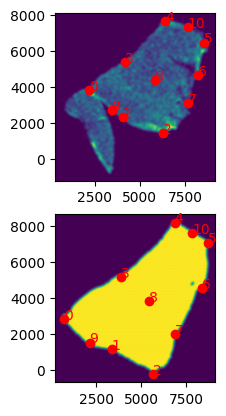

In [29]:


# get extent of images
extentAZ = STalign.extent_from_x((YA,XA))
extentAZM = STalign.extent_from_x((YAM,XAM))

# plot rasterized images
fig,ax = plt.subplots(2,1)
ax[0].imshow((AZ.transpose(1,2,0).squeeze()), extent=extentAZ) # just want 201x276 matrix
ax[1].imshow((AZM.transpose(1,2,0).squeeze()), extent=extentAZM) # just want 201x276 matrix
# with points
ax[0].scatter(pointsST[:,1], pointsST[:,0], c='red')
ax[1].scatter(pointsSM[:,1], pointsSM[:,0], c='red')
for i in range(pointsST.shape[0]):
    ax[0].text(pointsST[i,1],pointsST[i,0],f'{i}', c='red')
    ax[1].text(pointsSM[i,1],pointsSM[i,0],f'{i}', c='red')
ax[0].invert_yaxis()
ax[1].invert_yaxis()

In [30]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

In [31]:
# compute initial affine transformation from points
L,T = STalign.L_T_from_points(pointsST, pointsSM)
A = STalign.to_A(torch.tensor(L),torch.tensor(T))

CPU times: user 5min 24s, sys: 4.4 s, total: 5min 29s
Wall time: 2min 47s


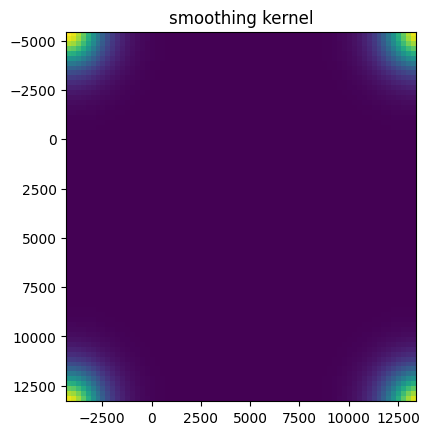

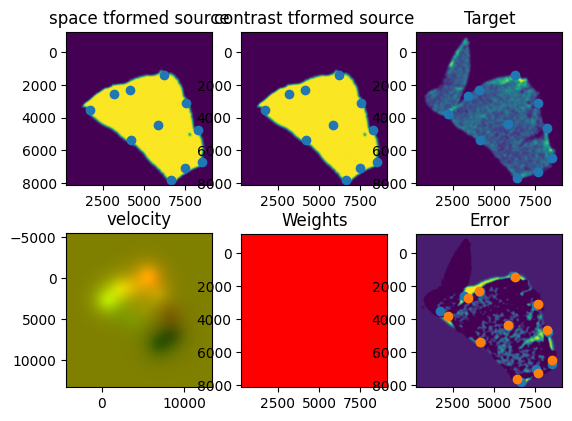

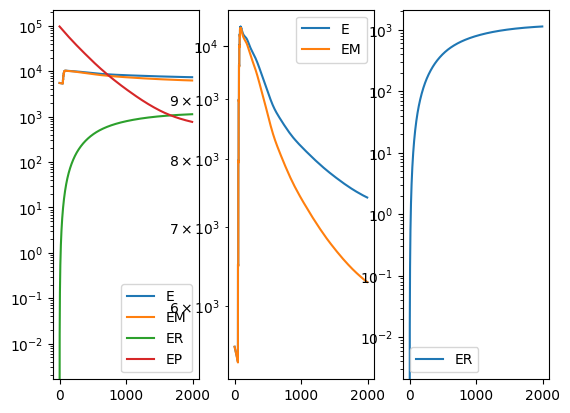

In [47]:
%%time
# run LDDMM (Large Deformation Diffeomorphic Metric Mapping)
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default

params = {
    'L': L,      # Integer: Number of time steps for the ODE solver
    'T': T,      # Float: Total time for the ODE integration (typically 1.0)

    'niter': 2000,  # Integer: Maximum number of iterations for the optimization

    # 'pointsI': pointsI,  # List/array: Source points coordinates
    # 'pointsJ': pointsJ,  # List/array: Target points coordinates

    'device': device,  # String: Computation device ('cpu' or 'cuda:X')
    'pointsI':pointsSM,
    'pointsJ':pointsST,

    #When using points it's better to omit these 
    #'sigmaM': 0.4,  # Float: Kernel width for the momentum field (controls local deformation)
    #'sigmaB': 1.2,  # Float: Kernel width for the backward map (controls smoothness of backward transformation)
    #'sigmaA': 1.2,  # Float: Kernel width for the forward map (controls smoothness of forward transformation)

    'epV': 100    # Float: Regularization parameter for the velocity field (higher values = more regularization)

    # Other parameters not specified but available:
    # 'alpha': Float - Weight for the data attachment term
    # 'beta': Float - Weight for the regularization term
    # 'gamma': Float - Weight for the landmark matching term (if landmarks are used)
    # 'lr': Float - Learning rate for the optimizer
    # 'optimizer': String - Type of optimizer to use (e.g., 'adam', 'sgd')
    # 'verbose': Boolean - Whether to print progress information
    # 'saveHistory': Boolean - Whether to save the optimization history
    # 'earlyStoppingPatience': Integer - Number of iterations without improvement before stopping
}

# remember the input is Y,X (row, column coordinates)
# Parameters for LDDMM:
# [YAM,XAM] - Source point coordinates (moving image)
# AZM - Source image intensity values
# [YA,XA] - Target point coordinates (fixed image)
# AZ - Target image intensity values
outA = STalign.LDDMM([YAM,XAM], AZM, [YA,XA], AZ, **params)


In [48]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

A = outA['A']
v = outA['v']
xv = outA['xv']
tpointsBA = STalign.transform_points_source_to_target(xv,v,A,np.stack([yA_met,xA_met],1))
tpointsBA=tpointsBA.cpu().numpy()
xB_LDDMM = tpointsBA[:,0]
yB_LDDMM = tpointsBA[:,1]
xF_n=xB_LDDMM + 0
yF_n=yB_LDDMM - 0

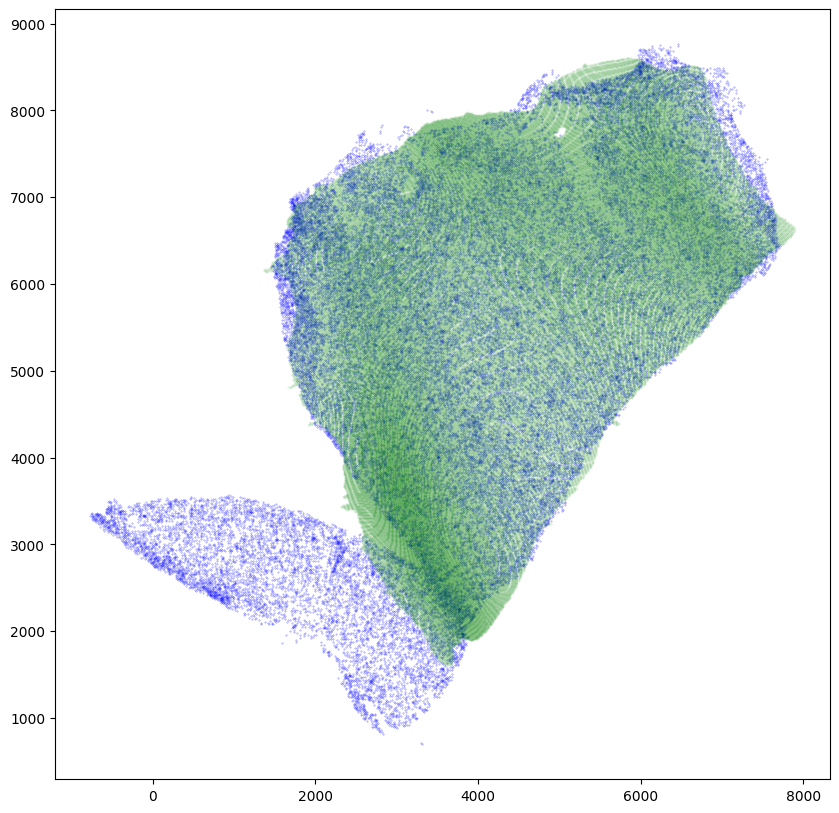

In [49]:
fig,ax = plt.subplots(figsize=(10,10))
#ax.imshow((I).transpose(1,2,0),extent=extentI)
ax.scatter(yA,xA,s=0.1,alpha=0.5, label='Z1',color='blue')
#ax.scatter(xB,yB,s=1,alpha=0.9, label='xenium',color='green')
ax.scatter(xF_n,yF_n,s=0.1,alpha=0.2, label='Z3',color='green')
#ax.scatter(yA_met,xA_met,s=0.1,alpha=0.2, label='Z3',color='orange')
#ax.scatter(z2_t_hpc['y_transformed'],z2_t_hpc['x_transformed'],s=0.1,alpha=0.2, label='Z3',color='red')

In [50]:
#export final transformed coordinates
x=xF_n
y=yF_n
z=z1_met

aligned = np.stack((x,y),1)
headers_df1 = z.columns.tolist()
new_headers= headers_df1 + ['x_transformed','y_transformed']
results= np.hstack((z, aligned))
results_df = pd.DataFrame(results, columns=new_headers)
results_df.to_csv('/vast/projects/BCRL_Multi_Omics/venture_pt2/integrated/Ven2A_z1_tranformed_metabolites_coordinates.csv', index=False)

### If landmarks are not required

/vast/projects/BCRL_Multi_Omics/STalign_env/lib/python3.11/site-packages/STalign/STalign.py:1043: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
/vast/projects/BCRL_Multi_Omics/STalign_env/lib/python3.11/site-packages/STalign/STalign.py:1044: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
/vast/projects/BCRL_Multi_Omics/STalign_env/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  re

CPU times: user 9min 27s, sys: 3.7 s, total: 9min 31s
Wall time: 45.4 s


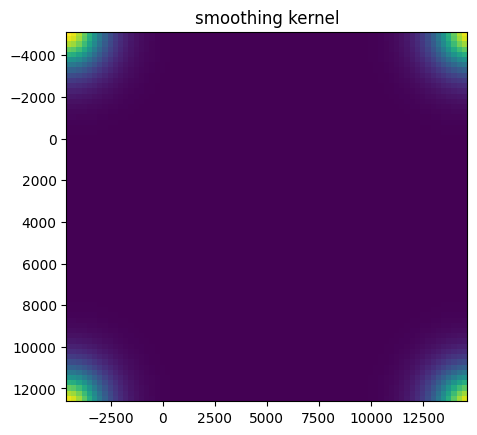

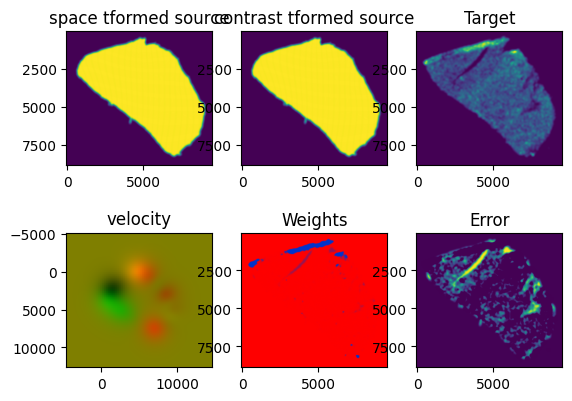

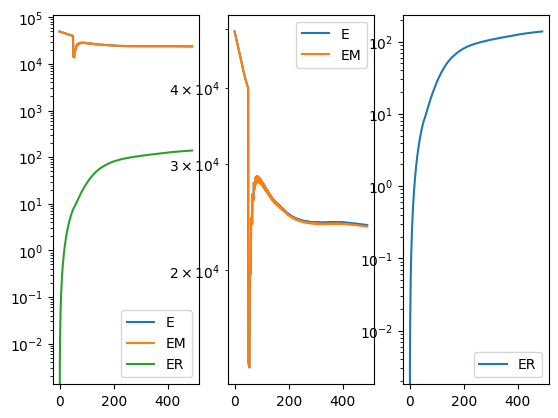

In [15]:
%%time
# run LDDMM (Large Deformation Diffeomorphic Metric Mapping)
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default

params = {
    #'L': L,      # Integer: Number of time steps for the ODE solver
    #'T': T,      # Float: Total time for the ODE integration (typically 1.0)

    'niter': 500,  # Integer: Maximum number of iterations for the optimization

    # 'pointsI': pointsI,  # List/array: Source points coordinates
    # 'pointsJ': pointsJ,  # List/array: Target points coordinates

    'device': device,  # String: Computation device ('cpu' or 'cuda:X')

    'sigmaM': 0.3,  # Float: Kernel width for the momentum field (controls local deformation)
    'sigmaB': 1.8,  # Float: Kernel width for the backward map (controls smoothness of backward transformation)
    'sigmaA': 1.8,  # Float: Kernel width for the forward map (controls smoothness of forward transformation)

    'epV': 200    # Float: Regularization parameter for the velocity field (higher values = more regularization)

    # Other parameters not specified but available:
    # 'alpha': Float - Weight for the data attachment term
    # 'beta': Float - Weight for the regularization term
    # 'gamma': Float - Weight for the landmark matching term (if landmarks are used)
    # 'lr': Float - Learning rate for the optimizer
    # 'optimizer': String - Type of optimizer to use (e.g., 'adam', 'sgd')
    # 'verbose': Boolean - Whether to print progress information
    # 'saveHistory': Boolean - Whether to save the optimization history
    # 'earlyStoppingPatience': Integer - Number of iterations without improvement before stopping
}
outC = STalign.LDDMM([YCM, XCM], CZM, [YC, XC], CZ, **params)

In [16]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

A = outC['A']
v = outC['v']
xv = outC['xv']
tpointsBA = STalign.transform_points_source_to_target(xv,v,A,np.stack([yC_met,xC_met],1))
tpointsBA=tpointsBA.cpu().numpy()
xB_LDDMM = tpointsBA[:,0]
yB_LDDMM = tpointsBA[:,1]
xF_n=xB_LDDMM + 0
yF_n=yB_LDDMM - 0

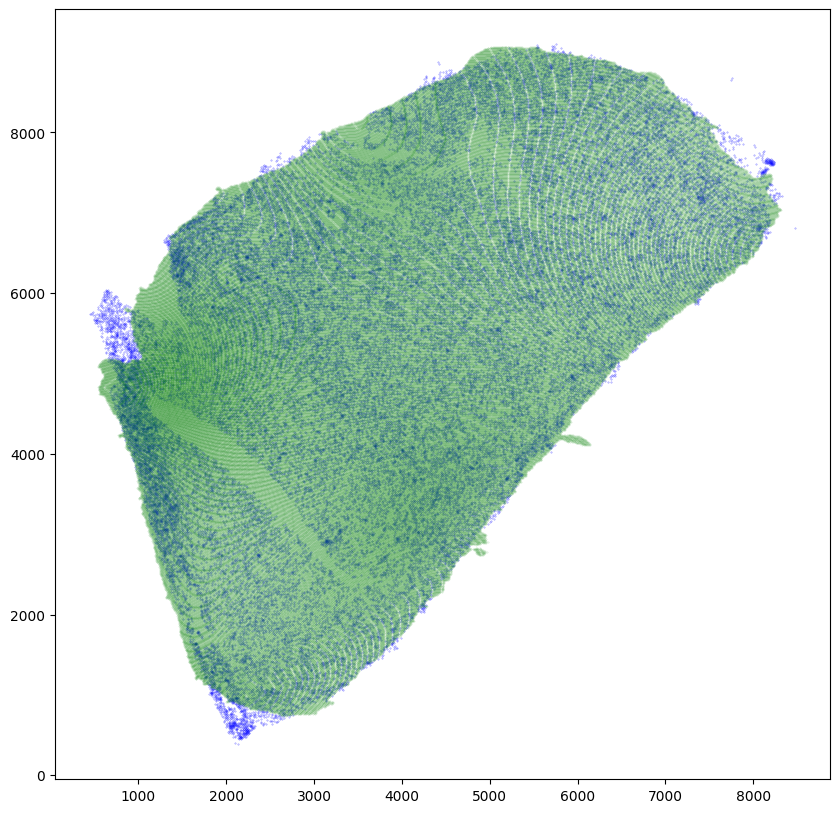

In [17]:
fig,ax = plt.subplots(figsize=(10,10))
#ax.imshow((I).transpose(1,2,0),extent=extentI)
ax.scatter(yC,xC,s=0.1,alpha=0.5, label='Z1',color='blue')
#ax.scatter(xB,yB,s=1,alpha=0.9, label='xenium',color='green')
ax.scatter(xF_n,yF_n,s=0.1,alpha=0.2, label='Z3',color='green')
#ax.scatter(yA_met,xA_met,s=0.1,alpha=0.2, label='Z3',color='orange')
#ax.scatter(z2_t_hpc['y_transformed'],z2_t_hpc['x_transformed'],s=0.1,alpha=0.2, label='Z3',color='red')

In [148]:
#export transformed matrix
x=xF_n
y=yF_n
z=z3_met

aligned = np.stack((x,y),1)
headers_df1 = z.columns.tolist()
new_headers= headers_df1 + ['x_transformed','y_transformed']
results= np.hstack((z, aligned))
results_df = pd.DataFrame(results, columns=new_headers)
results_df.to_csv('/vast/projects/BCRL_Multi_Omics/venture_pt2/integrated/Ven2C_z3_tranformed_metabolites_coordinates.csv', index=False)